In [1]:
!conda list | find "cudnn"

pytorch                   1.13.1          py3.9_cuda11.6_cudnn8_0    pytorch


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import numpy as np

In [8]:
# 1. torchvision을 사용하여 CIFAR10을 불러오고 정규화 하기

# Compose(), 여러 변환 작업을 단일 파이프라인으로 연결
transform = transforms.Compose(
    # ToTensor(), Python Image Library or Numpy 배열인 입력 이미지를 파이토치 텐서로 변환
    [transforms.ToTensor(),
    # 평균 및 표준 편차로 tensor 정규화, 각 채널의 평균값(RGB), 각 채널의 표준편차 값
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# ImageNet이 학습한 수백만장의 이미지의 RGB 각각의 채널에 대한 평균은 0.485, 0.456, 0.406 그리고 표준편차는 0.229, 0.224, 0.225

# 모델 입장에서 가장 좋은 값은 0 ~ 1 사이의 값
# 엄청나게 무수히 많은 값이 정수면 너무 커져버린다.
# 모델을 학습할 때 모든 데이터는 0 ~ 1사이의 값으로 정규화를 한 후에 학습을 시킨다.
# image 데이터는 0 ~ 255 사이인데 정규화 하기 위해서 Normailization 하는 것

# 각 미니 배치에 64개의 샘플이 포함됨
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform) # transforms.Compose()를 사용하여 이전에 정의된 변환 파이프라인으로 설정
testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=4) # num_workers : 데이터 로드에 사용할 하위 프로세스 수
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size, 
                                         shuffle=False, 
                                         num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


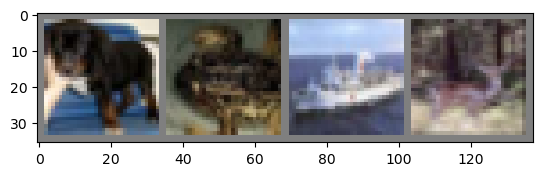

dog   frog  ship  deer 


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# 2. torchvision.models.ResNet
model = torchvision.models.resnet50(pretrained=True)

## CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# 3. 손실 함수 정의
# 손실 함수는 그냥 이거 쓰고
criterion = nn.CrossEntropyLoss()
# lr = 0.001이 conventionally 많이 사용
optimizer = optim.Adam(model.parameters(), lr=0.01) #  momentum=0.9

# Adam도 많이 사용한다. 
# 이걸로 결과가 어떻게 달라지는지 보는 것도 흥미로울 것
# lr= 1은 주면 안되고 0.1 ~ 1e-6


In [ ]:
# 4. 학습용 데이터를 사용하여 신경망 학습

# es = EarlyStopping(patience = 3, 
#                    delta=0, 
#                    mode='min', 
#                    verbose=True
#                   )

epochs = 50

for epoch in range(epochs):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # inputs, labels = data # cuda 사용
        # cuda(gpu)로 데이터를 넘겨줘야 한다.
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        # 손실 함수의 loss 결과 값을 그래프로 보면 될 것
        # batch마다 출력하고 있으니 epoch 끝날 때 마다 평균내서 출력해야 한다.
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

#        # EarlyStopping
#         es(loss.item())
#         print(f'[{epoch + 1}] loss: {loss.item():.3f}')
#         # Early Stop Check
#         if es.early_stop:
#             break

        # 통계를 출력
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

        # F1-score 구할 때 function은 cpu에서 돌아가야 할 것
        # 다시 cpu로 가져오기 위해서 data.to(cpu)

print('Finished Training')


# 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)



In [ ]:
# 5. 시험용 데이터로 신경망 검사하기
dataiter = iter(testloader)
images, labels = next(dataiter)

In [ ]:
# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
PATH = './cifar_net.pth'

# 저장했던 모델 불러오기
model = torchvision.models.resnet50(pretrained=True)
model.load_state_dict(torch.load(PATH))
outputs = model(images)

In [ ]:
# 시험용 데이터 불러오기

dataiter = iter(testloader)
images, labels = next(dataiter)

model = torchvision.models.resnet50(pretrained=True)
model.load_state_dict(torch.load(PATH))
model.eval()

# Gradients are still not needed
with torch.no_grad():
    y_true = []
    y_pred = []
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.cpu().numpy())

f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {f1:.3f}')

In [ ]:
# 가장 높은 값을 갖는 인덱스(index)를 뽑기
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# 결과 기록

- 하이퍼파라미터: 모델 학습 시 사람이 정해줘야하는 설정 값/함수 (위 코드에서 주의깊게 봐야할 사항)
    - Loss : 모델 예측값과 정답의 오차
    - Optimizer : 모델 학습 결과를 업데이트하는 방법
    - Learning Rate : 학습률. 모델 업데이트 시 반영할 비율
    - Epoch : 반복 학습 횟수
    - Batch_size : 학습 데이터를 분할하여 학습할 때 몇 개씩 할건지 정의
    
    
batch size : 64
optimizer : SGD
learning rate :  0.01
epoch : 50


1) early stopping 적용(patience 3 per loss) :  
    loss : [50] loss: 1.394
    ```
    Accuracy for class: plane is 48.0 %
    Accuracy for class: car   is 75.0 %
    Accuracy for class: bird  is 23.0 %
    Accuracy for class: cat   is 22.1 %
    Accuracy for class: deer  is 13.0 %
    Accuracy for class: dog   is 34.5 %
    Accuracy for class: frog  is 66.6 %
    Accuracy for class: horse is 66.6 %
    Accuracy for class: ship  is 51.3 %
    Accuracy for class: truck is 27.3 %
    ```
2) 미적용 :  
    loss : [50,   600] loss: 0.010  
    ```
    Accuracy for class: plane is 82.9 %
    Accuracy for class: car   is 85.0 %
    Accuracy for class: bird  is 69.9 %
    Accuracy for class: cat   is 61.4 %
    Accuracy for class: deer  is 79.4 %
    Accuracy for class: dog   is 59.6 %
    Accuracy for class: frog  is 87.5 %
    Accuracy for class: horse is 82.2 %
    Accuracy for class: ship  is 86.7 %
    Accuracy for class: truck is 83.3 %
    ```
    
    

batch size : 64  
optimizer : Adam()  
learning rate :  0.01  
epoch : 50  
```
loss : [50,   600] loss: 0.055
Accuracy for class: plane is 80.4 %
Accuracy for class: car   is 85.1 %
Accuracy for class: bird  is 58.1 %
Accuracy for class: cat   is 58.3 %
Accuracy for class: deer  is 76.0 %
Accuracy for class: dog   is 64.6 %
Accuracy for class: frog  is 84.4 %
Accuracy for class: horse is 83.6 %
Accuracy for class: ship  is 87.2 %
Accuracy for class: truck is 84.6 %
```